In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#from keras.models import *
from keras.models import Sequential, Model  # Importar Model para modelos funcionales
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import numpy as np
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Input  # Importar Input para definir la entrada
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt

In [4]:
#Carga de datos de los diferentes CSV´s
patient_data = pd.read_csv('PatientCorePopulatedTable.txt', sep='\t') 
labs_data = pd.read_csv('LabsCorePopulatedTable.txt', sep='\t')
diagnosis_data = pd.read_csv('AdmissionsDiagnosesCorePopulatedTable.txt', sep='\t')
admisions_data = pd.read_csv('AdmissionsCorePopulatedTable.txt', sep='\t')

In [5]:
#Para poder unir las tablas, necesitamos concatenar PatientID con su correpondiente AdmissionId para tener una clave única que relacione las tablas
labs_data["P+A"] = labs_data["PatientID"] + labs_data["AdmissionID"].map(str)
diagnosis_data["P+A"] = diagnosis_data["PatientID"] + diagnosis_data["AdmissionID"].map(str)
admisions_data["P+A"] = admisions_data["PatientID"] + admisions_data["AdmissionID"].map(str)

In [6]:
#Pivotamos la tabla de datos de laboratorio para que cada prueba sea una columna en lugar de una fila
labs_data_pivote = labs_data.pivot_table(index='P+A', columns=['LabName','LabUnits'], values='LabValue', fill_value=-100)

In [7]:
labs_data_pivote.isin([-100]).any().any()

True

In [8]:
#Para no tener dos niveles, concatenamos LabName y LabUnits
labs_data_pivote.columns = pd.MultiIndex.from_tuples(labs_data_pivote.columns, names=['LabName', 'LabUnits'])

# Concatenar los nombres de los niveles y establecer como índice único
labs_data_pivote.columns = labs_data_pivote.columns.get_level_values('LabName') + ' (' + labs_data_pivote.columns.get_level_values('LabUnits') + ')'

In [9]:
#Mergeamos labs_data_pivote y diagnosis_data
merged_df = pd.merge(labs_data_pivote, diagnosis_data, on='P+A')

#Mergeamos el anterior df con admisions_data
merged_df = pd.merge(merged_df, admisions_data, on='P+A', how='outer')

In [10]:
selected_columns = merged_df[['PatientID_x', 'PatientID_y']]

In [11]:
merged_df.columns

Index(['P+A', 'CBC: ABSOLUTE LYMPHOCYTES (%)', 'CBC: ABSOLUTE NEUTROPHILS (%)',
       'CBC: BASOPHILS (k/cumm)', 'CBC: EOSINOPHILS (k/cumm)',
       'CBC: HEMATOCRIT (%)', 'CBC: HEMOGLOBIN (gm/dl)',
       'CBC: LYMPHOCYTES (k/cumm)', 'CBC: MCH (pg)', 'CBC: MCHC (g/dl)',
       'CBC: MEAN CORPUSCULAR VOLUME (fl)', 'CBC: MONOCYTES (k/cumm)',
       'CBC: NEUTROPHILS (k/cumm)', 'CBC: PLATELET COUNT (k/cumm)',
       'CBC: RDW (%)', 'CBC: RED BLOOD CELL COUNT (m/cumm)',
       'CBC: WHITE BLOOD CELL COUNT (k/cumm)', 'METABOLIC: ALBUMIN (gm/dL)',
       'METABOLIC: ALK PHOS (U/L)', 'METABOLIC: ALT/SGPT (U/L)',
       'METABOLIC: ANION GAP (mmol/L)', 'METABOLIC: AST/SGOT (U/L)',
       'METABOLIC: BILI TOTAL (mg/dL)', 'METABOLIC: BUN (mg/dL)',
       'METABOLIC: CALCIUM (mg/dL)', 'METABOLIC: CARBON DIOXIDE (mmol/L)',
       'METABOLIC: CHLORIDE (mmol/L)', 'METABOLIC: CREATININE (mg/dL)',
       'METABOLIC: GLUCOSE (mg/dL)', 'METABOLIC: POTASSIUM (mmol/L)',
       'METABOLIC: SODIUM (mmol/L

In [12]:
merged_df['PatientID'] = merged_df['PatientID_x']

In [13]:
# Luego, fusionamos el resultado con el tercer DataFrame
merged_df = pd.merge(merged_df, patient_data, on='PatientID', how='outer')

In [14]:
#Calculamos la edad de cada paciente en el momento de la admisión
merged_df['Edad'] = 2024 - pd.to_datetime(merged_df['PatientDateOfBirth']).dt.year

In [15]:
# Eliminar Columnas No Necesarias
merged_df.drop(['P+A', 'PatientDateOfBirth', 'PatientID_x', 'PatientID_y',
                'PrimaryDiagnosisDescription', 'PatientPopulationPercentageBelowPoverty',
                'AdmissionID_x', 'AdmissionID_y'
              ], axis=1, inplace=True)

In [16]:
# Función para determinar el capítulo basado en el diagnóstico
def obtener_capitulo(diagnostico):
    # Extraemos los primeros tres caracteres del diagnóstico
    codigo = diagnostico[:3]
    # Convertimos el código a un número
    codigo_num = ord(codigo[0]) * 100 + int(codigo[1:2])

    # Definimos los rangos y capítulos usando los valores ordinales
    capitulos = [
        (ord('A') * 100, ord('B') * 100 + 99, '1'),
        (ord('C') * 100, ord('D') * 100 + 48, '2'),
        (ord('D') * 100 + 50, ord('D') * 100 + 89, '3'),
        (ord('E') * 100, ord('E') * 100 + 90, '4'),
        (ord('F') * 100, ord('F') * 100 + 99, '5'),
        (ord('G') * 100, ord('G') * 100 + 99, '6'),
        (ord('H') * 100, ord('H') * 100 + 59, '7'),
        (ord('H') * 100 + 60, ord('H') * 100 + 95, '8'),
        (ord('I') * 100, ord('I') * 100 + 99, '9'),
        (ord('J') * 100, ord('J') * 100 + 99, '10'),
        (ord('K') * 100, ord('K') * 100 + 93, '11'),
        (ord('L') * 100, ord('L') * 100 + 99, '12'),
        (ord('M') * 100, ord('M') * 100 + 99, '13'),
        (ord('N') * 100, ord('N') * 100 + 99, '14'),
        (ord('O') * 100, ord('O') * 100 + 99, '15'),
        (ord('P') * 100, ord('P') * 100 + 96, '16'),
        (ord('Q') * 100, ord('Q') * 100 + 99, '17'),
        (ord('R') * 100, ord('R') * 100 + 99, '18'),
        (ord('S') * 100, ord('T') * 100 + 98, '19'),
        (ord('V') * 100, ord('Y') * 100 + 98, '20'),
        (ord('Z') * 100, ord('Z') * 100 + 99, '21'),
        (ord('U') * 100, ord('U') * 100 + 99, '22')
    ]

    # Comparamos el código numérico con los rangos definidos
    for inicio, fin, capitulo in capitulos:
        if inicio <= codigo_num <= fin:
            return capitulo
    return 'Capítulo no encontrado'

# Aplicamos la función a la columna de diagnósticos
merged_df['PrimaryDiagnosisChapter'] = merged_df['PrimaryDiagnosisCode'].apply(obtener_capitulo)

In [17]:
#Aplicamos OneHot encoder a las variables que no tienen demasiados datos distintos
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder()

# Ajustar y transformar las columnas 'PatientGender' y 'PatientMaritalStatus' con el encoder
encoded_columns = encoder.fit_transform(merged_df[['PatientGender', 'PatientMaritalStatus']])

# Convertir el resultado en una matriz densa
encoded_columns_dense = encoded_columns.toarray()

# Obtener los nombres de las nuevas columnas
column_names = encoder.get_feature_names_out(['PatientGender', 'PatientMaritalStatus'])

# Crear el DataFrame con los datos codificados y los nombres de columnas correctos
encoded_df = pd.DataFrame(encoded_columns_dense, columns=column_names)

# Concatenar el DataFrame codificado con el original, excluyendo las columnas originales
merged_df = pd.concat([merged_df.drop(['PatientGender', 'PatientMaritalStatus'], axis=1), encoded_df], axis=1)
df = merged_df
df

,CBC: ABSOLUTE LYMPHOCYTES (%),CBC: ABSOLUTE NEUTROPHILS (%),CBC: BASOPHILS (k/cumm),CBC: EOSINOPHILS (k/cumm),CBC: HEMATOCRIT (%),CBC: HEMOGLOBIN (gm/dl),CBC: LYMPHOCYTES (k/cumm),CBC: MCH (pg),CBC: MCHC (g/dl),CBC: MEAN CORPUSCULAR VOLUME (fl),...,Edad,PrimaryDiagnosisChapter,PatientGender_Female,PatientGender_Male,PatientMaritalStatus_Divorced,PatientMaritalStatus_Married,PatientMaritalStatus_Separated,PatientMaritalStatus_Single,PatientMaritalStatus_Unknown,PatientMaritalStatus_Widowed
0,21.050000,69.300000,0.125000,0.275000,43.500000,13.060000,3.650000,29.283333,32.280000,83.000000,...,64,15,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,29.850000,72.360000,0.080000,0.400000,39.380000,14.875000,3.500000,34.533333,33.600000,85.475000,...,64,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,24.240000,67.566667,0.077778,0.322222,35.712500,14.350000,2.850000,29.228571,32.211111,85.460000,...,64,9,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,22.571429,70.925000,0.083333,0.233333,41.200000,15.087500,3.733333,32.255556,33.257143,84.820000,...,64,15,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,28.383333,66.588889,0.166667,0.357143,44.250000,13.155556,3.280000,30.528571,32.944444,80.066667,...,64,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,25.566667,67.816667,0.100000,0.400000,42.442857,13.280000,3.022222,29.150000,33.400000,80.840000,...,69,11,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
368,25.383333,69.800000,0.122222,0.300000,47.200000,14.800000,2.528571,27.511111,32.366667,84.875000,...,69,2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
369,25.886667,68.686667,0.109091,0.357143,42.676923,14.309091,2.587500,29.636364,33.557143,87.193333,...,83,5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
370,27.800000,68.660000,0.085714,0.414286,40.614286,13.877778,3.360000,31.811111,34.154545,83.833333,...,83,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [18]:
#Como no podemos utilizar el formato datetime, obtenemos dos nuevas columnas calculando AdmissionDuration y TimeSinceLastAdmision

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split


# Convertir fechas a datetime 
df['AdmissionStartDate'] = pd.to_datetime(df['AdmissionStartDate'])
df['AdmissionEndDate'] = pd.to_datetime(df['AdmissionEndDate'])

# Calcular la duración de la admisión y el tiempo desde la última admisión
df['AdmissionDuration'] = (df['AdmissionEndDate'] - df['AdmissionStartDate']).dt.total_seconds() / 3600
df = df.sort_values(['PatientID', 'AdmissionStartDate'])
df['TimeSinceLastAdmission'] = df.groupby('PatientID')['AdmissionStartDate'].diff().dt.total_seconds() / 3600


#
# Definir columnas numéricas y categóricas
numeric_columns = ['CBC: ABSOLUTE LYMPHOCYTES (%)', 'CBC: ABSOLUTE NEUTROPHILS (%)',
                   'CBC: BASOPHILS (k/cumm)', 'CBC: EOSINOPHILS (k/cumm)',
                   'CBC: HEMATOCRIT (%)', 'CBC: HEMOGLOBIN (gm/dl)',
                   'CBC: LYMPHOCYTES (k/cumm)', 'CBC: MCH (pg)', 'CBC: MCHC (g/dl)',
                   'CBC: MEAN CORPUSCULAR VOLUME (fl)', 'CBC: MONOCYTES (k/cumm)',
                   'CBC: NEUTROPHILS (k/cumm)', 'CBC: PLATELET COUNT (k/cumm)',
                   'CBC: RDW (%)', 'CBC: RED BLOOD CELL COUNT (m/cumm)',
                   'CBC: WHITE BLOOD CELL COUNT (k/cumm)', 'METABOLIC: ALBUMIN (gm/dL)',
                   'METABOLIC: ALK PHOS (U/L)', 'METABOLIC: ALT/SGPT (U/L)',
                   'METABOLIC: ANION GAP (mmol/L)', 'METABOLIC: AST/SGOT (U/L)',
                   'METABOLIC: BILI TOTAL (mg/dL)', 'METABOLIC: BUN (mg/dL)',
                   'METABOLIC: CALCIUM (mg/dL)', 'METABOLIC: CARBON DIOXIDE (mmol/L)',
                   'METABOLIC: CHLORIDE (mmol/L)', 'METABOLIC: CREATININE (mg/dL)',
                   'METABOLIC: GLUCOSE (mg/dL)', 'METABOLIC: POTASSIUM (mmol/L)',
                   'METABOLIC: SODIUM (mmol/L)', 'METABOLIC: TOTAL PROTEIN (gm/dL)',
                   'URINALYSIS: PH (no unit)', 'URINALYSIS: RED BLOOD CELLS (rbc/hpf)',
                   'URINALYSIS: SPECIFIC GRAVITY (no unit)',
                   'URINALYSIS: WHITE BLOOD CELLS (wbc/hpf)', 'Edad',
                   'AdmissionDuration', 'TimeSinceLastAdmission']

for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

#Aplicamos mapeo de frecuencia para no darle un peso quivocado a las variables
# Columnas para mapeo de frecuencia
frequency_map_columns = ['PatientLanguage', 'PrimaryDiagnosisCode', 'PatientRace']

# Aplicar mapeo de frecuencia
for col in frequency_map_columns:
    frequency_map = df[col].value_counts().to_dict()
    df[col] = df[col].map(frequency_map)

df = df.dropna(axis=0)
columns = [col for col in df.columns if col != 'PrimaryDiagnosisChapter'] + ['PrimaryDiagnosisChapter']
df = df[columns]

In [19]:
df.columns

Index(['CBC: ABSOLUTE LYMPHOCYTES (%)', 'CBC: ABSOLUTE NEUTROPHILS (%)',
       'CBC: BASOPHILS (k/cumm)', 'CBC: EOSINOPHILS (k/cumm)',
       'CBC: HEMATOCRIT (%)', 'CBC: HEMOGLOBIN (gm/dl)',
       'CBC: LYMPHOCYTES (k/cumm)', 'CBC: MCH (pg)', 'CBC: MCHC (g/dl)',
       'CBC: MEAN CORPUSCULAR VOLUME (fl)', 'CBC: MONOCYTES (k/cumm)',
       'CBC: NEUTROPHILS (k/cumm)', 'CBC: PLATELET COUNT (k/cumm)',
       'CBC: RDW (%)', 'CBC: RED BLOOD CELL COUNT (m/cumm)',
       'CBC: WHITE BLOOD CELL COUNT (k/cumm)', 'METABOLIC: ALBUMIN (gm/dL)',
       'METABOLIC: ALK PHOS (U/L)', 'METABOLIC: ALT/SGPT (U/L)',
       'METABOLIC: ANION GAP (mmol/L)', 'METABOLIC: AST/SGOT (U/L)',
       'METABOLIC: BILI TOTAL (mg/dL)', 'METABOLIC: BUN (mg/dL)',
       'METABOLIC: CALCIUM (mg/dL)', 'METABOLIC: CARBON DIOXIDE (mmol/L)',
       'METABOLIC: CHLORIDE (mmol/L)', 'METABOLIC: CREATININE (mg/dL)',
       'METABOLIC: GLUCOSE (mg/dL)', 'METABOLIC: POTASSIUM (mmol/L)',
       'METABOLIC: SODIUM (mmol/L)', 'ME

In [20]:
df.drop(columns=['AdmissionStartDate', 'AdmissionEndDate', 'PatientID', 'PrimaryDiagnosisCode'], inplace=True)

In [49]:
df.to_csv('df_MODELO.csv', index=False)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0415 - loss: 3.9547 - val_accuracy: 0.0000e+00 - val_loss: 3.8260 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0369 - loss: 3.9084 - val_accuracy: 0.0364 - val_loss: 3.8060 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0415 - loss: 3.8638 - val_accuracy: 0.0909 - val_loss: 3.7906 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0783 - loss: 3.7989 - val_accuracy: 0.1091 - val_loss: 3.7765 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0829 - loss: 3.7951 - val_accuracy: 0.2000 - val_loss: 3.7634 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0876 - loss: 3.7723 - val_accuracy: 0.2545 - val_loss: 3.7540 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1106 - loss: 3.7332 - val_accuracy

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 512)                 │          25,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 22)                  │             726 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 601,124 (2.29 MB)

 Trainable params: 200,374 (782.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 400,750 (1.53 MB)

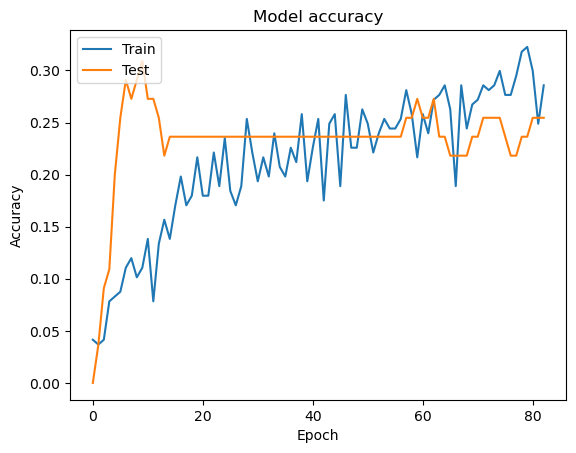

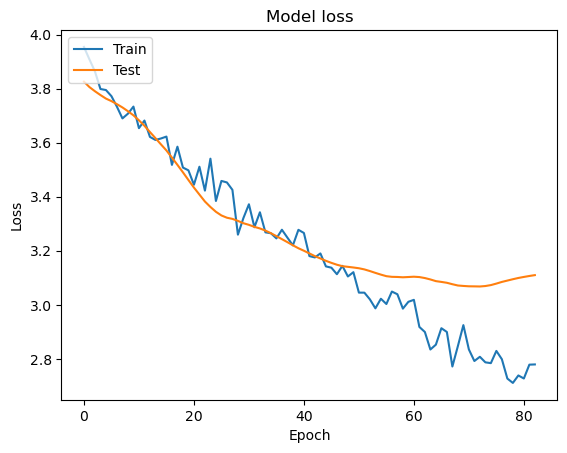

In [58]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model  # Importar Model para modelos funcionales
from keras.layers import Dense, Dropout, Input  # Importar Input para definir la entrada
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import joblib

# Assuming df is your DataFrame
# Separar Características y Etiquetas
X = df.drop(['PrimaryDiagnosisChapter'], axis=1)
y = df['PrimaryDiagnosisChapter']

# Preprocesamiento de datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convertir las etiquetas categóricas a one-hot encoding
y = to_categorical(y)

# División de los Datos en Entrenamiento y Prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

joblib.dump(X_train, 'X_train.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test, 'y_test.pkl')

# Definir el modelo de deep learning
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Definir la entrada
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Nueva capa
    Dropout(0.4),  # Nueva capa Dropout
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  # Nueva capa
    Dropout(0.4),  # Nueva capa Dropout
    Dense(y_train.shape[1], activation='softmax')
])

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Definir los callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint, lr_scheduler])

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Resumen del modelo
model.summary()

model.save('modelo_series_temporales.h5')

# Analizar el historial de entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Modelo original

In [42]:
X_train.shape

(217, 48)

In [43]:
y_test.shape

(55, 15)

In [36]:
y_train.shape

(76, 22)

In [37]:
X_test.shape

(20, 6, 47)

In [38]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Definir la entrada
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

# Compilar el modelo
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Definir los callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_100k.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=400, batch_size=4096, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint, lr_scheduler])

model.save('model_sequential.h5')

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Resumen del modelo
model.summary()

# Analizar el historial de entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


C:\Users\piran\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1579 - loss: 4.3305 - val_accuracy: 0.2000 - val_loss: 4.3330 - learning_rate: 1.0000e-05
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.1053 - loss: 4.3264 - val_accuracy: 0.2000 - val_loss: 4.3322 - learning_rate: 1.0000e-05
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.1447 - loss: 4.3231 - val_accuracy: 0.2000 - val_loss: 4.3314 - learning_rate: 1.0000e-05
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.0658 - loss: 4.3286 - val_accuracy: 0.2000 - val_loss: 4.3306 - learning_rate: 1.0000e-05
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.1711 - loss: 4.3233 - val_accuracy: 0.2000 - val_loss: 4.3299 - learning_rate: 1.0000e-05
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.1184 - loss: 4.3233 - val_accuracy: 0.2000 - val_loss: 4.3292 - learning_rate: 1.0000e-05
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.1316 - l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 512)         │     1,146,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 6, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 22)             │           726 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,427,556 (24.52 MB)

 Trainable params: 2,142,518 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,285,038 (16.35 MB)

In [63]:
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np

# Assuming X and y are your full dataset
n_splits = 5  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

def create_model(input_shape, output_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)), 
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)), 
        Dropout(0.3),
        Dense(output_shape, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.00001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cv_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    print(f"Fold {fold}")
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = create_model(X_train.shape[1], y_train.shape[1])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_model_fold_{fold}.keras', monitor='val_loss', save_best_only=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
    
    history = model.fit(
        X_train, y_train,
        epochs=400,
        batch_size=4096,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, checkpoint, lr_scheduler]
    )
    
    # Evaluate the model
    val_loss, val_acc = model.evaluate(X_val, y_val)
    cv_scores.append(val_acc)
    print(f"Fold {fold} - Validation Accuracy: {val_acc}")

print(f"Mean CV Accuracy: {np.mean(cv_scores)}")
print(f"Std CV Accuracy: {np.std(cv_scores)}")

Fold 1
Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1382 - loss: 3.4842 - val_accuracy: 0.2364 - val_loss: 3.4276 - learning_rate: 1.0000e-05
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1475 - loss: 3.4719 - val_accuracy: 0.2364 - val_loss: 3.4274 - learning_rate: 1.0000e-05
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1613 - loss: 3.4728 - val_accuracy: 0.2364 - val_loss: 3.4271 - learning_rate: 1.0000e-05
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1382 - loss: 3.4928 - val_accuracy: 0.2364 - val_loss: 3.4269 - learning_rate: 1.0000e-05
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1705 - loss: 3.4649 - val_accuracy: 0.2364 - val_loss: 3.4266 - learning_rate: 1.0000e-05
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1567 - loss: 3.4660 - val_accuracy: 0.2364 - val_loss: 3.4264 - learning_rate: 1.0000e-05
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1613 - 

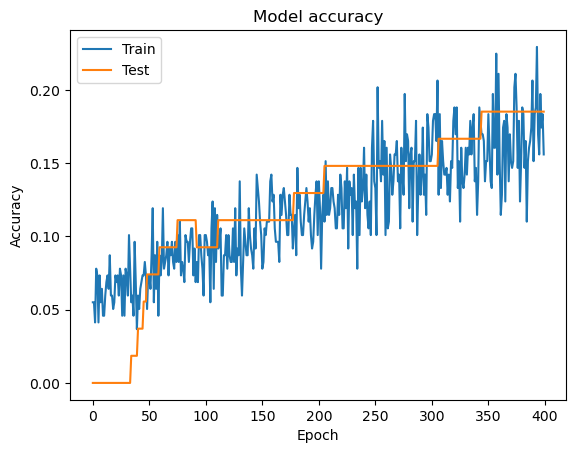

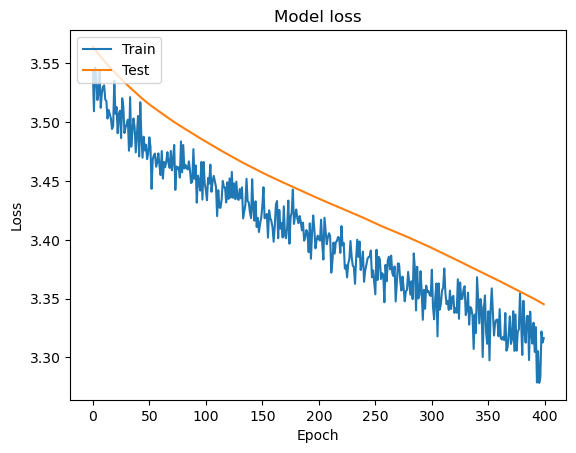

In [66]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Accuracy: 0.36363636363636365
F1 Score: 0.2761688311688312
Confusion Matrix:
[[ 0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  1  0  0]
 [ 0  0 14  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  3  0  0  2  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0]]


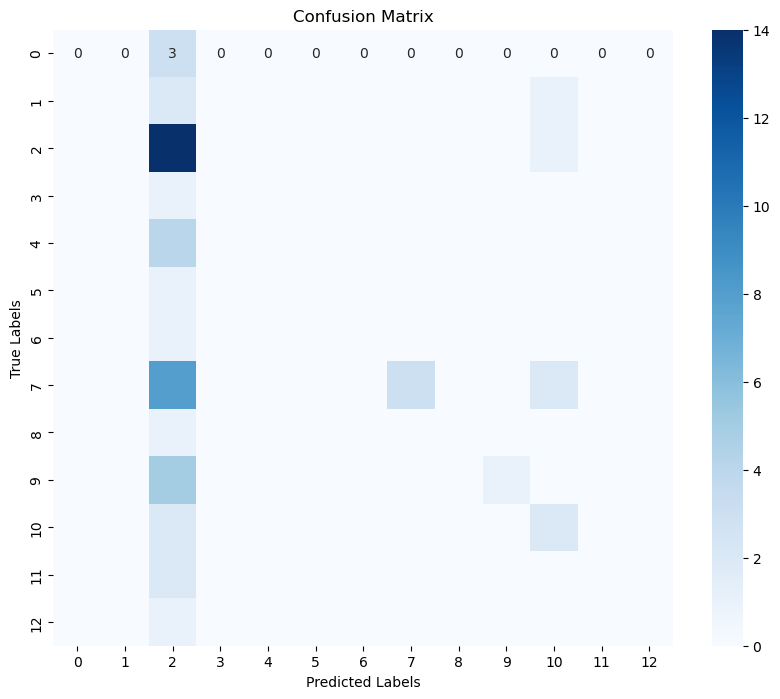

In [68]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.utils import to_categorical

# Suponiendo que 'y_test' y las predicciones del modelo están en formato de etiquetas enteras
# Si 'y_test' está en formato one-hot, primero conviértelo a etiquetas enteras
y_test_labels = np.argmax(y_test, axis=1)

# Realizar predicciones con el modelo
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Calcular la precisión
accuracy = accuracy_score(y_test_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

# Calcular el puntaje F1
f1 = f1_score(y_test_labels, predicted_labels, average='weighted')
print(f'F1 Score: {f1}')

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

# Visualizar la matriz de confusión
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [52]:
yhat = model.predict(X_test)
yhat_metrica = [np.argmax(x) for x in yhat]
y_test_metrica = [np.argmax(x) for x in y_test]
from sklearn.metrics import confusion_matrix

for x in confusion_matrix(y_test_metrica, yhat_metrica):
    print(list(x))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 4, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 7, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0]
[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [76]:
from sklearn.metrics import f1_score, classification_report

# Suponiendo que 'y_pred' son las predicciones de tu modelo y 'y_true' son las etiquetas verdaderas
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calcular el F1-score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'F1-score: {f1}')

# Para obtener un reporte completo con precision, recall y F1-score por clase
print(classification_report(y_true_classes, y_pred_classes))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
F1-score: 0.2761688311688312
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       0.31      0.93      0.47        15
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       1.00      0.23      0.38        13
           9       0.00      0.00      0.00         1
          10       1.00      0.17      0.29         6
          11       0.33      0.50      0.40         4
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1

    accuracy                           0.36        55
   macro avg       0.20      0.14      0.12        55
weighted avg       0.45      0.36      0.28        55



C:\Users\piran\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\piran\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\piran\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


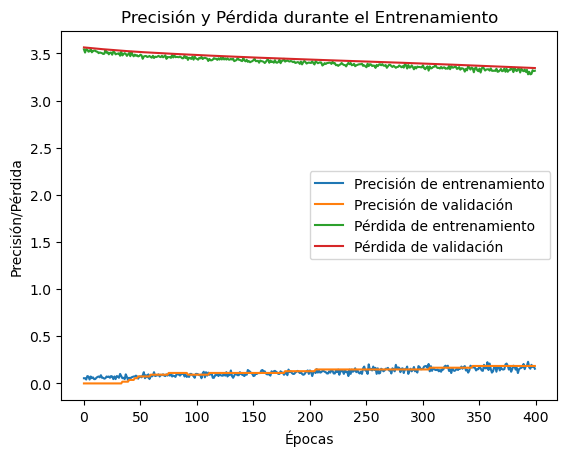

In [78]:
# Precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')

# Pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')

# Títulos y etiquetas
plt.title('Precisión y Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión/Pérdida')
plt.legend()

# Mostrar la gráfica
plt.show()
